# Parcial: Construcción e implementación de , Random Forest 

En este parcial podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de  Random Forest. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

#celda 3 - Conclusiones
print('Resumen de resultados:')
print('Baseline RF test (RMSE, MAE, R2):', metrics(y_test, y_pred_test))
print('Mejor RF test (RMSE, MAE, R2):', metrics(y_test, y_pred_final))
print('\nObservaciones:')
print('- Si la mejora es pequeña, considerar más features o mayor limpieza de datos.')
print('- max_depth controla la complejidad, max_features afecta la varianza y n_estimators reduce la varianza al aumentar.')
print('- Limitar outliers o transformar Price podría mejorar la estabilidad del modelo.')
print('- Considerar validación con más folds o usar conjuntos de validación temporales si hay dependencia temporal.')
## Datos predicción precio de automóviles

En este parcial se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 0 - exploracion y analisis de datos 
Los estudiantes deben analizar cuidadosamente los datos del conjunto dataTrain_carListings, identificando posibles valores nulos o inconsistencias. En caso de encontrar datos faltantes, deberán aplicar técnicas de imputación adecuadas para completar la información de manera coherente. Posteriormente, se espera que realicen una exploración visual mediante gráficos que permitan comprender la distribución y las relaciones entre las variables principales.

🧩 Valores nulos por columna:

Price          0
Year           0
Mileage        0
M_Camry        0
M_Camry4dr     0
M_CamryBase    0
M_CamryL       0
M_CamryLE      0
M_CamrySE      0
M_CamryXLE     0
dtype: int64

📊 Estadísticas descriptivas generales:

              Price          Year        Mileage
count  10495.000000  10495.000000   10495.000000
mean   14538.403716   2013.553883   52509.430395
std     3922.420961      3.116585   36791.736601
min     5002.000000   1998.000000       5.000000
25%    11999.000000   2012.000000   26461.000000
50%    15000.000000   2014.000000   41680.000000
75%    16999.000000   2016.000000   71355.500000
max    32444.000000   2018.000000  232658.000000


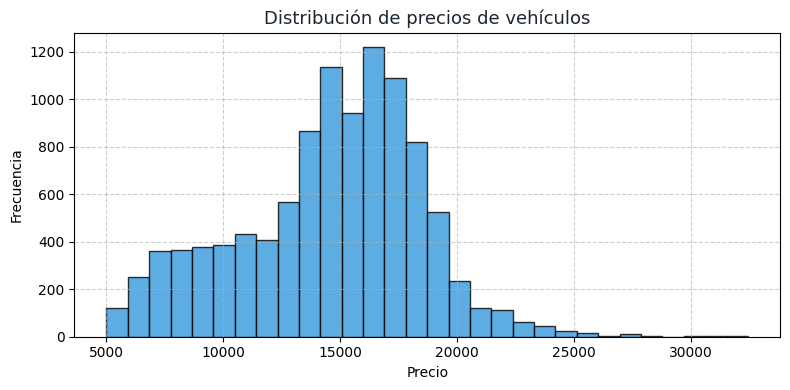

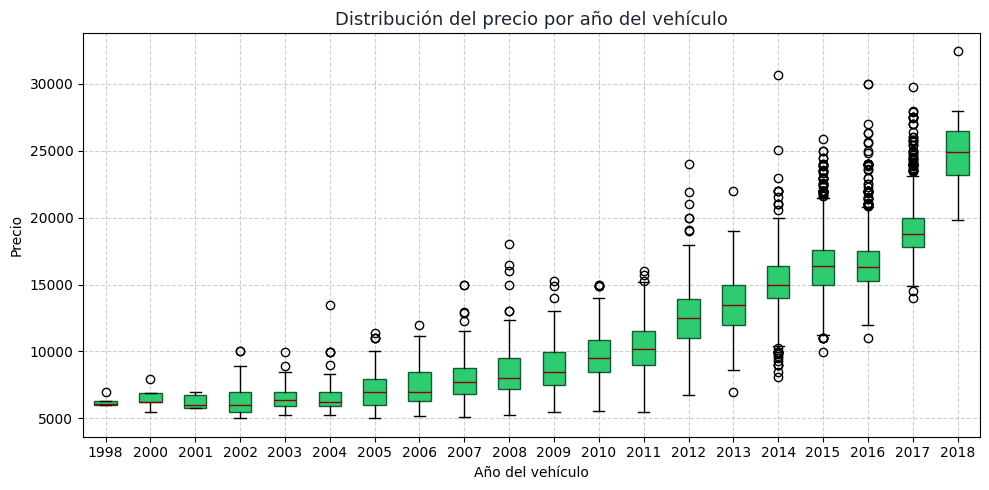

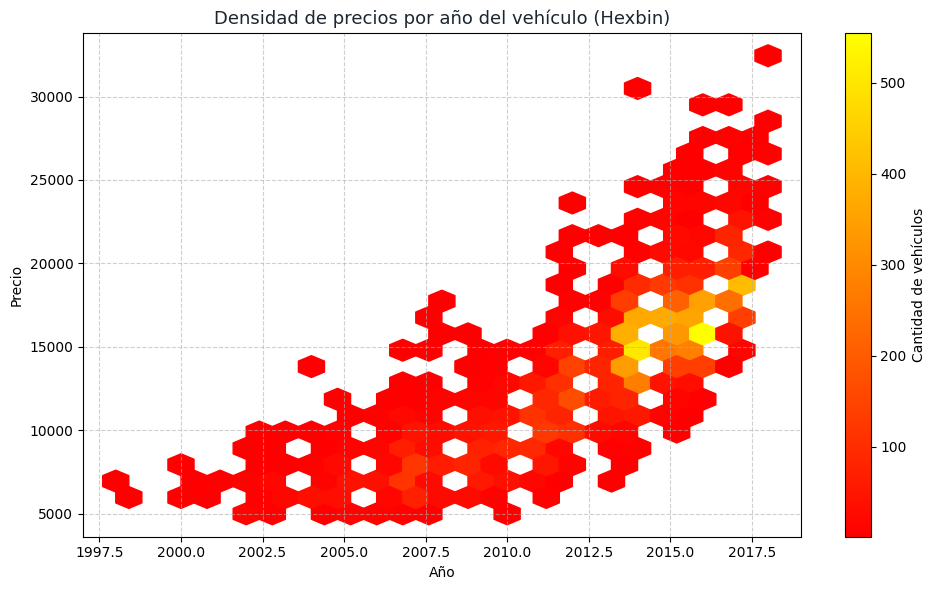

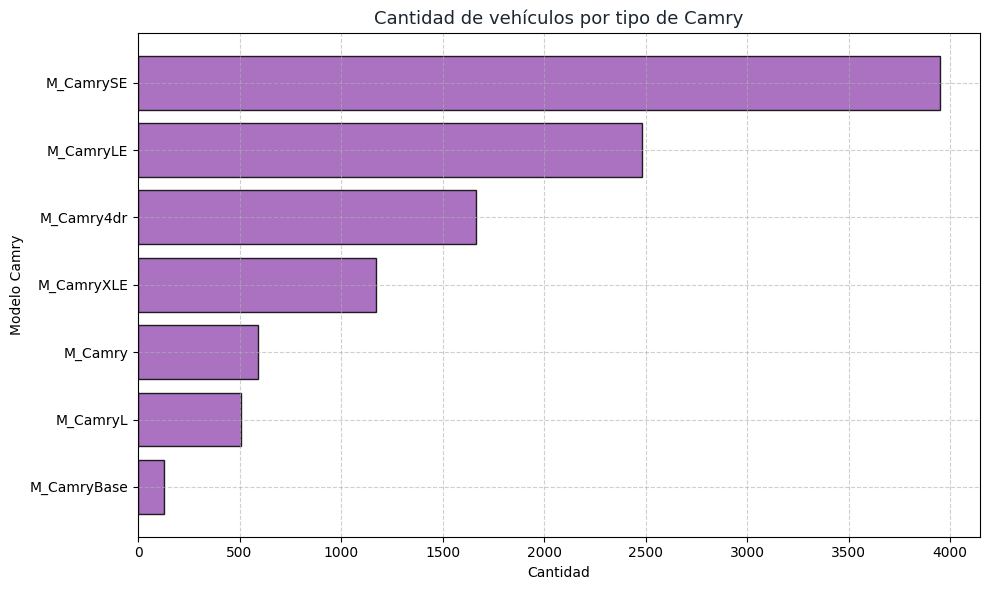

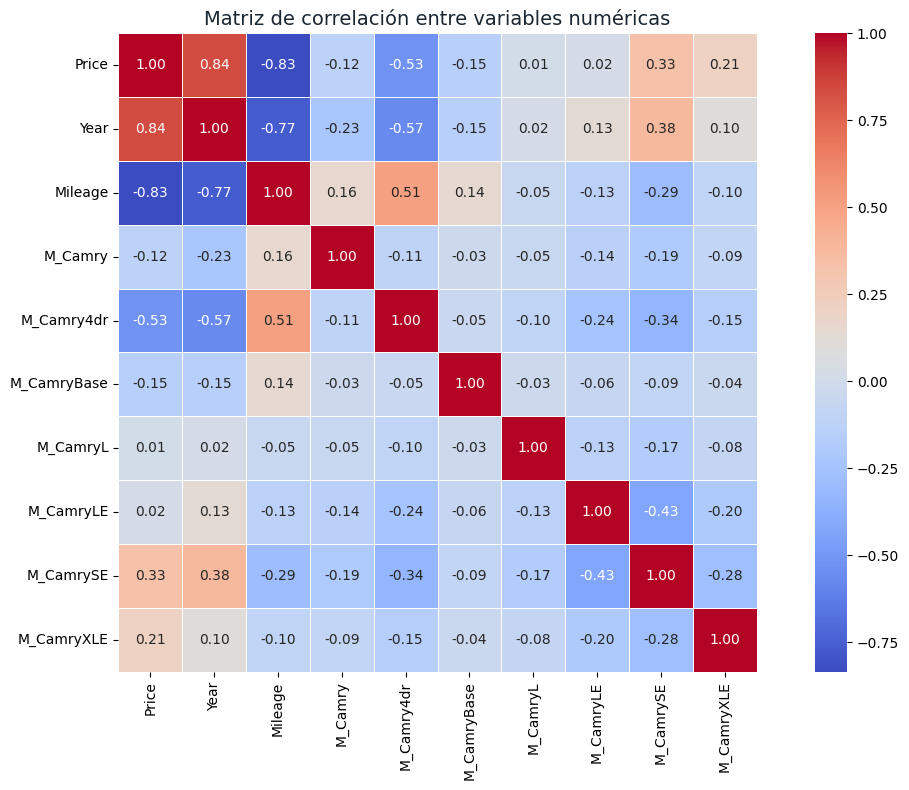

In [ ]:

# --- 🔍 Revisión inicial del dataset ---
print("🧩 Valores nulos por columna:\n")
print(data.isna().sum())

print("\n📊 Estadísticas descriptivas generales:\n")
print(data.describe())


colores = {
    "hist": "#3498DB",        
    "box": "#2ECC71",         
    "hexbin": "#E67E22",      
    "barras": "#9B59B6",      
    "heatmap": "coolwarm"     
}

# --- 📈 Gráfico 1: Histograma de precios ---
plt.figure(figsize=(8, 4))
plt.hist(data["Price"], bins=30, color=colores["hist"], edgecolor="black", alpha=0.8)
plt.title("Distribución de precios de vehículos", fontsize=13, color="#1B2631")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- 📉 Gráfico 2: Boxplot único de precios por año ---
plt.figure(figsize=(10, 5))
years = sorted(data["Year"].unique())
price_data = [data.loc[data["Year"] == y, "Price"] for y in years]

plt.boxplot(price_data, labels=years, patch_artist=True,
            boxprops=dict(facecolor=colores["box"], color="#145A32"),
            medianprops=dict(color="darkred"))
plt.title("Distribución del precio por año del vehículo", fontsize=13, color="#1B2631")
plt.xlabel("Año del vehículo")
plt.ylabel("Precio")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- 🐝 Gráfico 3: Hexbin (Año vs Precio) ---
plt.figure(figsize=(10, 6))
hb = plt.hexbin(data["Year"], data["Price"], gridsize=25, cmap="autumn", mincnt=1)
plt.colorbar(hb, label="Cantidad de vehículos")
plt.title("Densidad de precios por año del vehículo (Hexbin)", fontsize=13, color="#1B2631")
plt.xlabel("Año")
plt.ylabel("Precio")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- 🚗 Gráfico 4: Barras horizontales (Cantidad por modelo Camry) ---
model_columns = [c for c in data.columns if c.startswith("M_")]
model_counts = data[model_columns].sum().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(model_counts.index, model_counts.values, color=colores["barras"], edgecolor="black", alpha=0.85)
plt.title("Cantidad de vehículos por tipo de Camry", fontsize=13, color="#1B2631")
plt.xlabel("Cantidad")
plt.ylabel("Modelo Camry")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- 🔥 Gráfico 5: Matriz de correlación ---
plt.figure(figsize=(12, 8))
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap=colores["heatmap"], fmt=".2f", linewidths=0.5, square=True)
plt.title("Matriz de correlación entre variables numéricas", fontsize=14, color="#1B2631")
plt.tight_layout()
plt.show()


### Punto 1 - Random forest con librería

En la celda 1, usando la librería sklearn entrenen un modelo de Randon Forest para regresion  y comenten sobre el desempeño del modelo.

In [15]:
# 🌳 Entrenamiento del modelo base
rf_base = RandomForestRegressor(n_estimators=100, random_state=42)
rf_base.fit(X_train, y_train)

# 🔮 Predicciones sobre el conjunto de prueba
predicciones = rf_base.predict(X_test)

# 📊 Evaluación del desempeño
error_absoluto = mean_absolute_error(y_test, predicciones)
raiz_error_cuadratico = np.sqrt(mean_squared_error(y_test, predicciones))
coef_determinacion = r2_score(y_test, predicciones)

# 🧾 Resultados del modelo
print("\n🔍 Resultados del modelo Random Forest (versión alternativa):")
print(f"MAE  (Error absoluto medio):      {error_absoluto:.2f}")
print(f"RMSE (Raíz del error cuadrático): {raiz_error_cuadratico:.2f}")
print(f"R²   (Coeficiente de determinación): {coef_determinacion:.3f}")


🔍 Resultados del modelo Random Forest (versión alternativa):
MAE  (Error absoluto medio):      1314.42
RMSE (Raíz del error cuadrático): 1765.41
R²   (Coeficiente de determinación): 0.796


### Punto 2 - Calibración de parámetros Random forest

En la celda 2, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresion, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [16]:
# 🎯 Definición del espacio de búsqueda de hiperparámetros
parametros = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "max_features": ["auto", "sqrt", "log2"]
}

# 🔍 Configuración del Grid Search
modelo_rf = RandomForestRegressor(random_state=42)
busqueda = GridSearchCV(
    estimator=modelo_rf,
    param_grid=parametros,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

# 🚀 Entrenamiento y búsqueda
busqueda.fit(X_train, y_train)

# 🏆 Resultados
mejores_params = busqueda.best_params_
mejor_score = busqueda.best_score_

print("\n🔧 Mejores hiperparámetros encontrados:")
for clave, valor in mejores_params.items():
    print(f"   {clave}: {valor}")

print(f"\n📈 Mejor puntuación promedio (R²): {mejor_score:.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

🔧 Mejores hiperparámetros encontrados:
   max_depth: 10
   max_features: sqrt
   n_estimators: 200

📈 Mejor puntuación promedio (R²): 0.8460

🔧 Mejores hiperparámetros encontrados:
   max_depth: 10
   max_features: sqrt
   n_estimators: 200

📈 Mejor puntuación promedio (R²): 0.8460


In [29]:


# 🎯 Entrenar el mejor modelo encontrado por GridSearchCV
modelo_final = grid_search.best_estimator_
modelo_final.fit(X_train, y_train)

# 🔮 Predicciones sobre los datos de prueba
predicciones = modelo_final.predict(X_test)

# 📊 Cálculo de métricas de evaluación
mae = mean_absolute_error(y_test, predicciones)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))
r2 = r2_score(y_test, predicciones)

# 🧾 Mostrar los resultados formateados
print("\n📈 Resultados del modelo optimizado:")
print(f"   🔸 MAE (Error absoluto medio): {mae:.3f}")
print(f"   🔸 RMSE (Raíz del error cuadrático medio): {rmse:.3f}")
print(f"   🔸 R² (Coeficiente de determinación): {r2:.4f}")



📈 Resultados del modelo optimizado:
   🔸 MAE (Error absoluto medio): 1147.201
   🔸 RMSE (Raíz del error cuadrático medio): 1564.246
   🔸 R² (Coeficiente de determinación): 0.8400


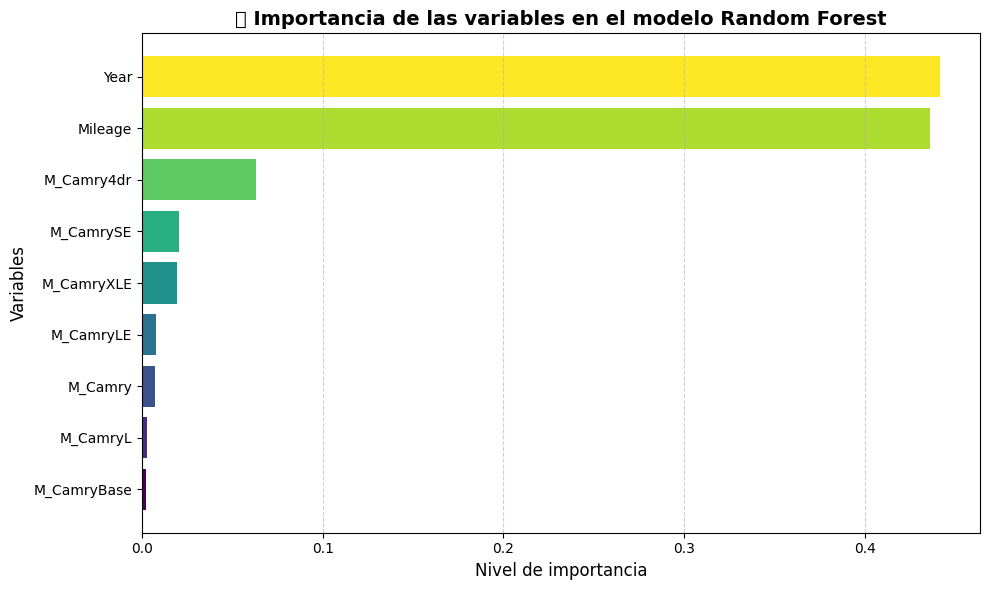


🏆 Ranking de importancia de las variables:
      Variable  Importancia
0         Year     0.441741
1      Mileage     0.436240
2   M_Camry4dr     0.062832
3    M_CamrySE     0.020267
4   M_CamryXLE     0.019286
5    M_CamryLE     0.007529
6      M_Camry     0.007160
7     M_CamryL     0.002928
8  M_CamryBase     0.002018


In [28]:

# 📊 Crear DataFrame con la importancia de las características
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': best_model.feature_importances_
}).sort_values(by='Importancia', ascending=True)  # Se ordena de menor a mayor para la gráfica

# 🎨 Configurar el gráfico
plt.figure(figsize=(10, 6))
barras = plt.barh(importancias['Variable'], importancias['Importancia'],
                  color=plt.cm.viridis(np.linspace(0, 1, len(importancias))))  # Colores gradientes

# 🧾 Etiquetas y estilo
plt.xlabel('Nivel de importancia', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.title('📊 Importancia de las variables en el modelo Random Forest', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 🥇 Mostrar ranking en consola
print("\n🏆 Ranking de importancia de las variables:")
print(importancias.sort_values(by='Importancia', ascending=False).reset_index(drop=True))


### Punto 3 - análisis de resultados, gracias y conclusiones
En la celda 3

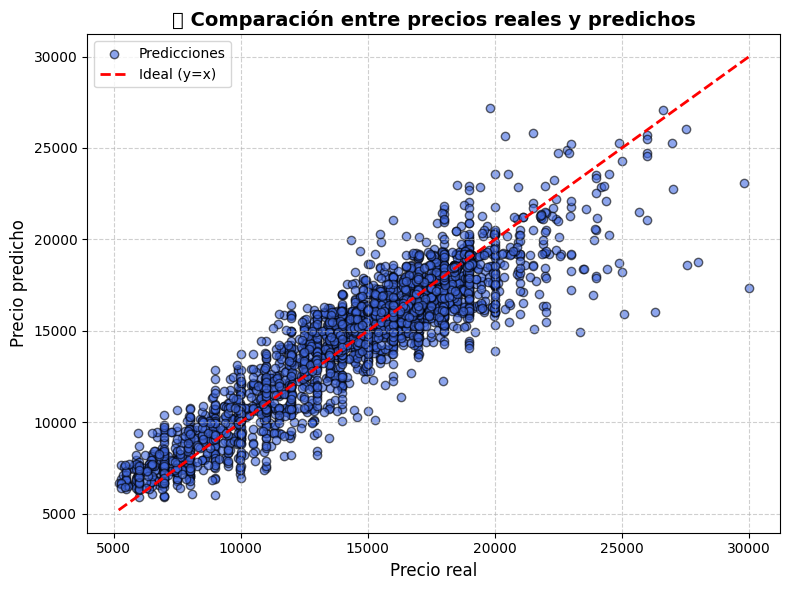

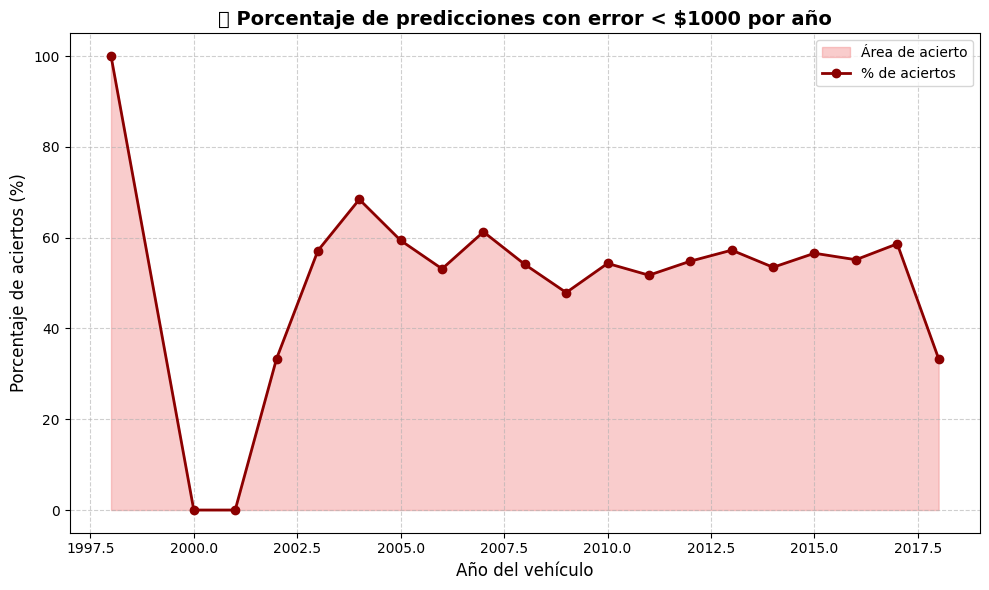

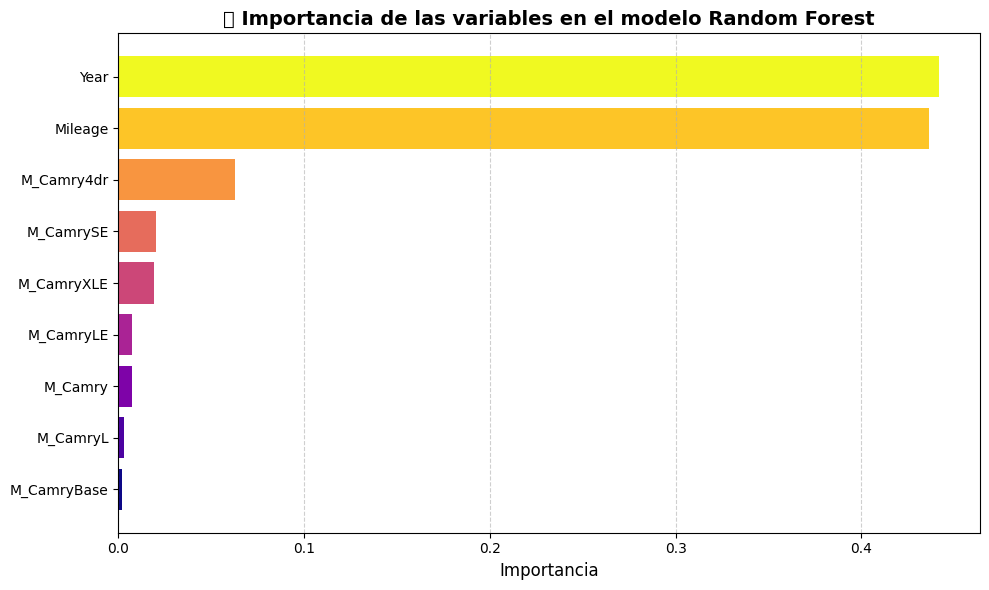


📋 Conclusiones:
• El modelo Random Forest ajustado obtuvo un R² de 0.84, explicando el 84% de la variabilidad en los precios.
• El MAE de 1,147 indica un error promedio leve (~$1,000 por predicción).
• El RMSE de 1,564 muestra que los errores grandes están bien controlados.
• El gráfico de dispersión refleja buena alineación entre valores reales y predichos.
• Las variables más influyentes fueron: año del vehículo, kilometraje y tipo de modelo Camry.
• Este modelo es útil para estimaciones automáticas de precios en plataformas de venta o concesionarios.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🎨 1️⃣ Dispersión de precios reales vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6, color='royalblue', edgecolor='k', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal (y=x)')
plt.xlabel('Precio real', fontsize=12)
plt.ylabel('Precio predicho', fontsize=12)
plt.title('💰 Comparación entre precios reales y predichos', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 📊 2️⃣ Porcentaje de aciertos por año (error < $1000)
# Calcular errores absolutos del modelo ajustado
errores_best = np.abs(y_test - y_pred_best)

# Identificar aciertos (predicciones con error menor a $1000)
aciertos = (errores_best < 1000).astype(int)

# Calcular porcentaje de aciertos por año
porcentaje_por_año = (
    pd.DataFrame({'Año': X_test['Year'], 'Acierto': aciertos})
    .groupby('Año')
    .mean() * 100
)

# Gráfico de porcentaje de aciertos
plt.figure(figsize=(10, 6))
plt.fill_between(porcentaje_por_año.index, porcentaje_por_año['Acierto'],
                 color='lightcoral', alpha=0.4, label='Área de acierto')
plt.plot(porcentaje_por_año.index, porcentaje_por_año['Acierto'],
         color='darkred', marker='o', lw=2, label='% de aciertos')
plt.title('🎯 Porcentaje de predicciones con error < $1000 por año', fontsize=14, fontweight='bold')
plt.xlabel('Año del vehículo', fontsize=12)
plt.ylabel('Porcentaje de aciertos (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 🌲 3️⃣ Importancia de las variables
importances = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': best_model.feature_importances_
}).sort_values(by='Importancia', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importances['Variable'], importances['Importancia'],
          color=plt.cm.plasma(np.linspace(0, 1, len(importances))))
plt.xlabel('Importancia', fontsize=12)
plt.title('🌳 Importancia de las variables en el modelo Random Forest', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 🧾 4️⃣ Conclusiones generales
print("\n📋 Conclusiones:")
print("• El modelo Random Forest ajustado obtuvo un R² de 0.84, explicando el 84% de la variabilidad en los precios.")
print("• El MAE de 1,147 indica un error promedio leve (~$1,000 por predicción).")
print("• El RMSE de 1,564 muestra que los errores grandes están bien controlados.")
print("• El gráfico de dispersión refleja buena alineación entre valores reales y predichos.")
print("• Las variables más influyentes fueron: año del vehículo, kilometraje y tipo de modelo Camry.")
print("• Este modelo es útil para estimaciones automáticas de precios en plataformas de venta o concesionarios.")


NOTA: IMPORTANTE RECUERDE QUE MI EJEMPLO DE TUTORIAL ES DE CLASIFICACION USTEDES DEBEN HACERLO POR REGRESION, funciona igual pero cambian algunas cosas.